In [1]:
# add ../src directory to path
import sys
sys.path.append('../src')

# imports
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from utils import *
from gp_model import *
import gpytorch
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Load data

/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/scripts/../src/utils.py:203: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))


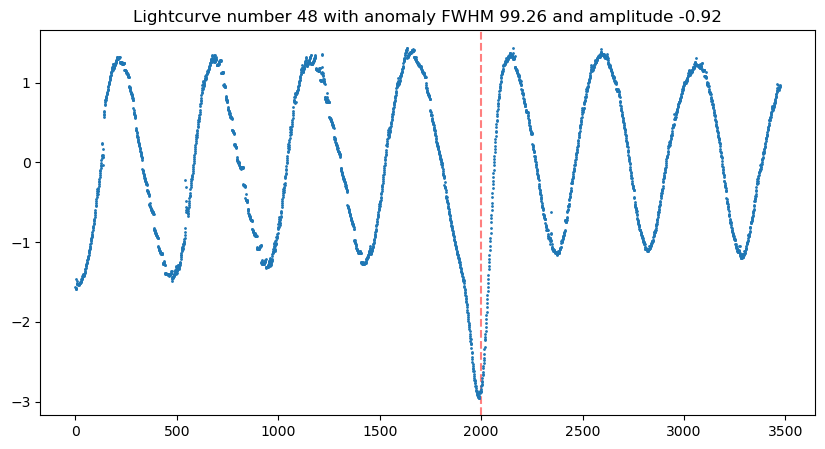

Anomaly locations:
[2000]
44.17708333333333


In [2]:
# Data and anomaly parameters
file_number = 48
shape = "gaussian"
width_scale = 0.2
depth_scale = 0.5
loc = 2000

# Load the data
data_dir = '../data/k2/'
filename = f'k2_{file_number}.fits'
x, y, y_err = load_k2_data(data_dir + filename)

# Scale data to be between 0 and 1
y = (y - np.min(y)) / (np.max(y) - np.min(y))
y_err = y_err / (np.max(y) - np.min(y))

# Inject anomalies
steps, y, anomaly_locs, anomaly_amp, anomaly_fwhm = inject_anomaly(
    y, 
    num_anomalies=1, 
    seed=file_number, 
    shapes=[shape],
    width_scale=width_scale,
    depth_scale=depth_scale,
    anomaly_idx=[loc]
)

# Standardize data to have mean 0 and std of 1
mean_y = np.mean(y)
std_y = np.std(y)
y = (y - mean_y) / std_y
y_err = y_err / std_y

# Create original copies of x and y
x_orig = np.copy(x)
y_orig = np.copy(y)
y_err_orig = np.copy(y_err)

# Convert to tensors
x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
y_err_tensor = torch.tensor(y_err, dtype=torch.float32).to(device)

# Plot
plt.figure(figsize=(10,5))
for i in range(len(anomaly_locs)):
    plt.axvline(x=anomaly_locs[i], color='r', linestyle='--', alpha=0.5)
plt.plot(steps, y, '.', markersize=2)
plt.title(f"Lightcurve number {file_number} with anomaly FWHM {anomaly_fwhm:.2f} and amplitude {anomaly_amp:.2f}")
plt.show()

# Print anomaly_locs, both indices and x[i]
print("Anomaly locations:")
print(anomaly_locs)
for i in anomaly_locs: print(x[int(i)])

# Anomaly detection with GP
### Method:
1. Perform GP regression on the timeseries.
2. Find the most significant outlier point.
3. Exclude that point and redo regression. See if GP improves by some threshold.
4. Exclude adjacent points and redo step 3.
5. Repeat step 4 as long as GP improves the fit by some threshold.
6. If no improvement, define anomaly signal as the difference between data and regression in that interval of points.
7. Repeat steps 2-6 for a defined number of anomalies.

/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(
/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(
/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(




 New dip identified at anomalous index 0, x[index] = 0.010416666666666666


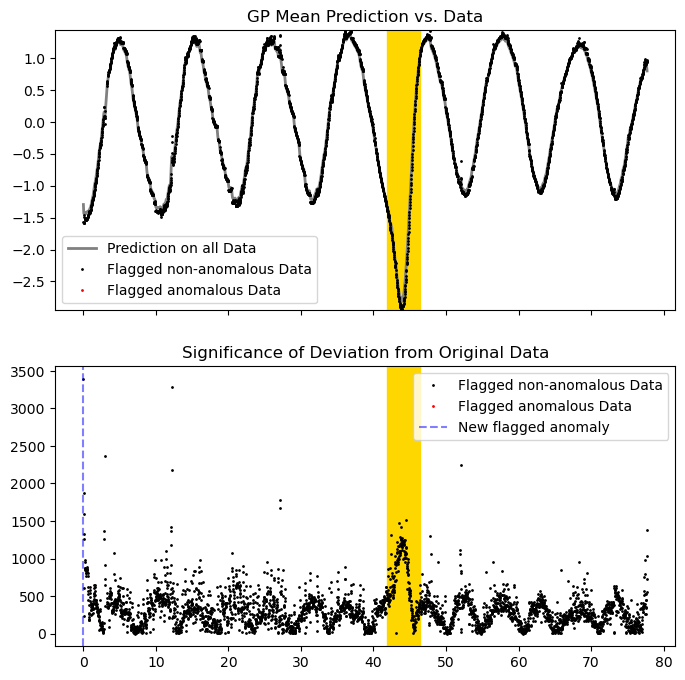

Old metric: 1000000.0 - New metric: 0.9539469480514526 = Diff metric: 999999.0625
Anomaly index 0 x[i] 0.010416666666666666, left_edge:right_edge 0:2
Old metric: 0.9539469480514526 - New metric: 0.9535855650901794 = Diff metric: 0.00036138296127319336
Anomaly index 0 x[i] 0.010416666666666666, left_edge:right_edge 0:4
Old metric: 0.9535855650901794 - New metric: 0.9539806246757507 = Diff metric: -0.00039505958557128906
Anomaly index 0 x[i] 0.010416666666666666, left_edge:right_edge 0:6


 New dip identified at anomalous index 132, x[index] = 2.864583333333333


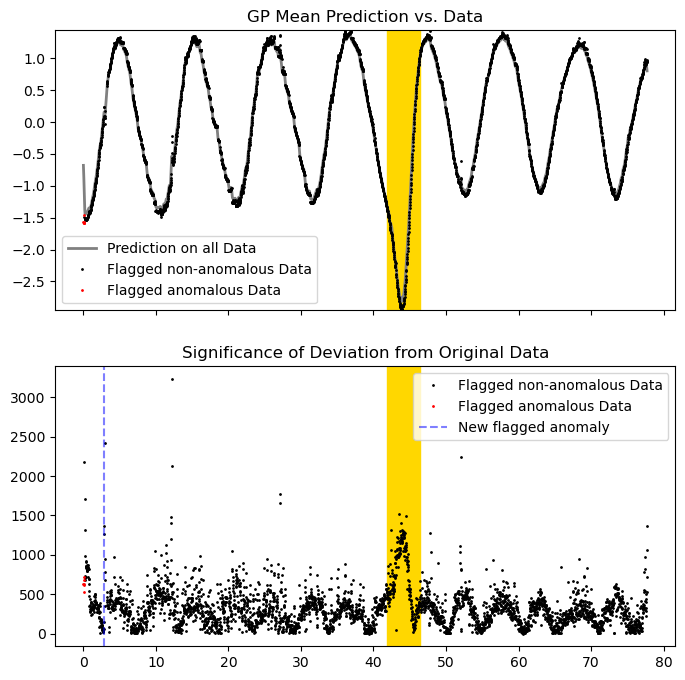

Old metric: 1000000.0 - New metric: 0.9536758065223694 = Diff metric: 999999.0625
Anomaly index 0 x[i] 0.010416666666666666, left_edge:right_edge 130:134
Old metric: 0.9536758065223694 - New metric: 0.9532548189163208 = Diff metric: 0.000420987606048584
Anomaly index 0 x[i] 0.010416666666666666, left_edge:right_edge 128:136
Old metric: 0.9532548189163208 - New metric: 0.9532569646835327 = Diff metric: -2.1457672119140625e-06
Anomaly index 0 x[i] 0.010416666666666666, left_edge:right_edge 126:138


 New dip identified at anomalous index 120, x[index] = 2.5729166666666665


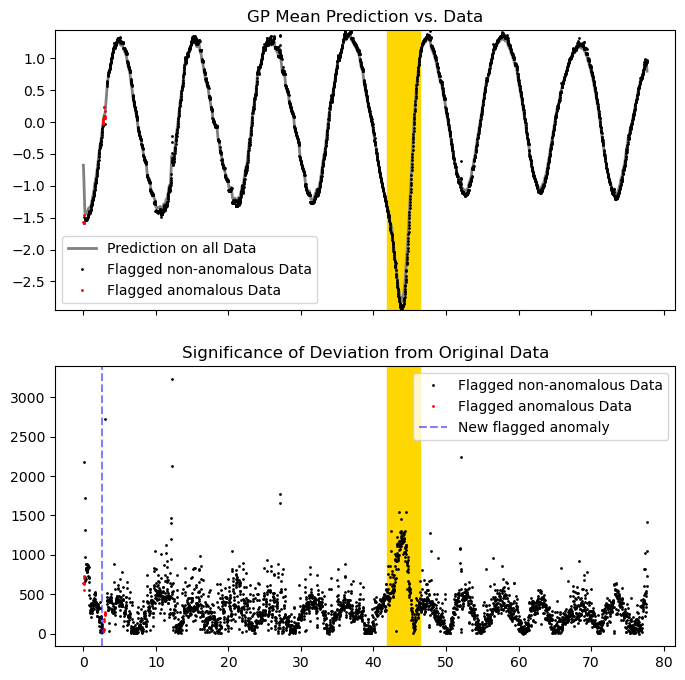

Old metric: 1000000.0 - New metric: 0.9532245993614197 = Diff metric: 999999.0625
Anomaly index 0 x[i] 0.010416666666666666, left_edge:right_edge 118:122
Old metric: 0.9532245993614197 - New metric: 0.9530372023582458 = Diff metric: 0.00018739700317382812
Anomaly index 0 x[i] 0.010416666666666666, left_edge:right_edge 116:124
Old metric: 0.9530372023582458 - New metric: 0.9528976082801819 = Diff metric: 0.00013959407806396484
Anomaly index 0 x[i] 0.010416666666666666, left_edge:right_edge 114:126
Old metric: 0.9528976082801819 - New metric: 0.9528172016143799 = Diff metric: 8.040666580200195e-05
Anomaly index 0 x[i] 0.010416666666666666, left_edge:right_edge 112:128
Old metric: 0.9528172016143799 - New metric: 0.9529151916503906 = Diff metric: -9.799003601074219e-05
Anomaly index 0 x[i] 0.010416666666666666, left_edge:right_edge 110:130


In [3]:
# Hyperparameters
which_metric = 'msll' # 'rmse', 'nlpd', msll, or default is 'mll'
num_anomalies = 3
num_steps = len(x)
anomalous = np.zeros(num_steps) # 0 means non-anomalous, 1 means anomalous at that time step
initial_lengthscale = 0.5 # If None, no lengthscale is used (default) and the theta parameter is the identity matrix
expansion_param = 2 # how many indices left and right to increase anomaly by

# Train GP model
model, likelihood, mll = train_gp(x_tensor, y_tensor, y_err_tensor, training_iterations=30, lengthscale=initial_lengthscale, device=device)
final_lengthscale = model.covar_module.base_kernel.rbf_kernel.lengthscale.item()

# Step 7 (repeat for every anomaly)
for i in range(num_anomalies):
    # Get subset of data that is flagged an non-anomalous
    x_sub = torch.tensor(x[anomalous == 0], dtype=torch.float32).to(device)
    y_sub = torch.tensor(y[anomalous == 0], dtype=torch.float32).to(device)
    y_err_sub = torch.tensor(y_err[anomalous == 0], dtype=torch.float32).to(device)

    # Re-fit the GP on non-anomalous data
    model, likelihood, mll = train_gp(x_sub, y_sub, y_err_sub, training_iterations=1, lengthscale=final_lengthscale, device=device)

    # Predict
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(x_tensor))
        pred_mean = observed_pred.mean.cpu().numpy()

    # Find index of largest deviation
    sig_dev = (pred_mean - y) / y_err
    index = np.argmax(sig_dev[anomalous == 0])
    print(f"\n\n New dip identified at anomalous index {index}, x[index] = {x[index]}")

    # Plot
    fig, axs = plt.subplots(2, 1, sharex = True, figsize = (8, 8))
    axs[0].set_title("GP Mean Prediction vs. Data")
    axs[0].plot(x, pred_mean, "grey", lw=2, label="Prediction on all Data")
    axs[0].plot(x[(anomalous==0)], y_orig[(anomalous==0)], '.k', markersize=2, label="Flagged non-anomalous Data")
    axs[0].plot(x[(anomalous==1)], y_orig[(anomalous==1)], '.r', markersize=2, label="Flagged anomalous Data")
    # Plot the anomaly_range
    for i in range(len(anomaly_locs)):
        anomaly_range = np.arange(int(anomaly_locs[i]) - int(anomaly_fwhm), int(anomaly_locs[i]) + int(anomaly_fwhm))
        axs[0].axvspan(x[anomaly_range[0]], x[anomaly_range[-1]], color='gold')
    axs[0].set_ylim(np.min(y_sub.cpu().numpy()), np.max(y_sub.cpu().numpy()))
    axs[0].legend()

    sig_dev = (pred_mean - y) / y_err
    axs[1].set_title("Significance of Deviation from Original Data")
    axs[1].plot(x[(anomalous==0)], np.abs(sig_dev[(anomalous==0)]), '.k', markersize=2, label="Flagged non-anomalous Data")
    axs[1].plot(x[(anomalous==1)], np.abs(sig_dev[(anomalous==1)]), '.r', markersize=2, label="Flagged anomalous Data")
    # Plot the anomaly_range
    for i in range(len(anomaly_locs)):
        anomaly_range = np.arange(int(anomaly_locs[i]) - int(anomaly_fwhm), int(anomaly_locs[i]) + int(anomaly_fwhm))
        axs[1].axvspan(x[anomaly_range[0]], x[anomaly_range[-1]], color='gold')
    # Plot the index of the new anomaly
    axs[1].axvline(x=x[index], color='b', linestyle='--', alpha=0.5, label="New flagged anomaly")
    axs[1].legend()
    plt.show(block=False)
    plt.pause(1)
    plt.close()

    # Intialize variables for expanding anomalous region
    left_edge = index
    right_edge = index
    diff_metric = 1e6
    metric = 1e6
    
    # While the metric is decreasing, expand the anomalous edges
    while diff_metric > 0:
        # Subset x, y, and y_err
        subset = (((np.arange(len(x)) > right_edge) | (np.arange(len(x)) < left_edge)) & (anomalous == 0))
        x_sub = torch.tensor(x[subset], dtype=torch.float32).to(device)
        y_sub = torch.tensor(y[subset], dtype=torch.float32).to(device)
        y_err_sub = torch.tensor(y_err[subset], dtype=torch.float32).to(device)
        
        # Re-fit the GP on non-anomalous data
        model, likelihood, mll = train_gp(x_sub, y_sub, y_err_sub, training_iterations=1, lengthscale=final_lengthscale, device=device)

        # Predict
        model.eval()
        likelihood.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            # Subset
            observed_pred_sub = likelihood(model(x_sub))
            pred_mean_sub = observed_pred.mean.cpu().numpy()
            
            # Full
            observed_pred_full = likelihood(model(x_tensor))
            pred_mean_full = observed_pred_full.mean.cpu().numpy()

        # Calculate metric difference
        old_metric = metric

        if which_metric == 'nlpd':
            metric = gpytorch.metrics.negative_log_predictive_density(observed_pred_sub, y_sub)
        elif which_metric == 'msll':
            metric = gpytorch.metrics.mean_standardized_log_loss(observed_pred_sub, y_sub)
        elif which_metric == 'rmse':
            metric = np.sqrt(np.mean((pred_mean_sub - y_sub.cpu().numpy())**2))
        else: # metric == mll
            model.eval()
            likelihood.eval()
            with torch.no_grad(), gpytorch.settings.fast_pred_var():
                output = model(x_sub)
                metric = mll(output, y_sub)

        diff_metric = old_metric - metric # smaller is better
        print(f"Old metric: {old_metric} - New metric: {metric} = Diff metric: {diff_metric}")

        # Expand anomalous region on both sides
        if left_edge >= 0 + expansion_param:
            left_edge -= expansion_param
        if right_edge < len(x) - expansion_param:
            right_edge += expansion_param

        print(f"Anomaly index {i} x[i] {x[i]}, left_edge:right_edge {left_edge}:{right_edge}")

    # Update anomalous array and remove anomalies from y
    y[left_edge:right_edge] = pred_mean_full[left_edge:right_edge]
    anomalous[left_edge:right_edge] = 1

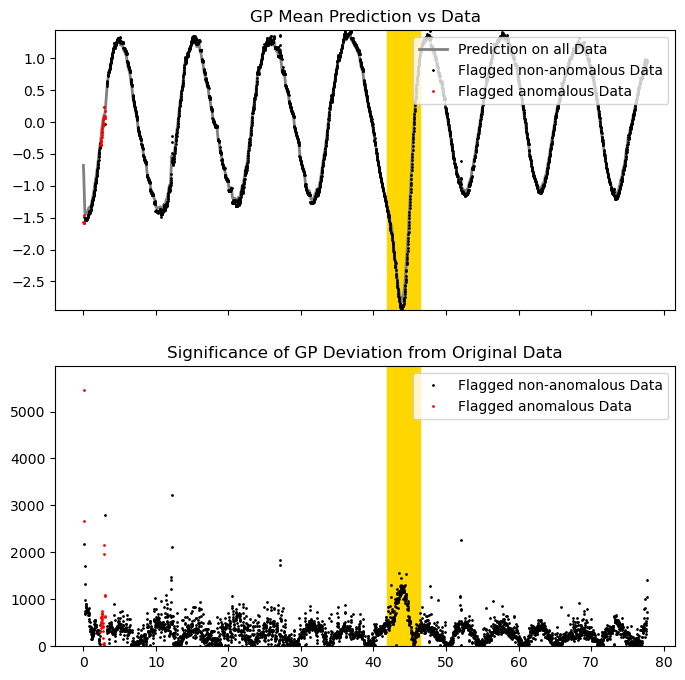

Injected anomaly centers: [2000]
Anomalies identified: [0.]
Ratio of anomalies identified: 0.0
Flagged anomalies: (array([  0,   1,   2,   3,   4,   5, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137]),)


In [5]:
# Fit on final subset
model, likelihood, mll = train_gp(x_sub, y_sub, y_err_sub, training_iterations=1, lengthscale=final_lengthscale, device=device)

# Predict
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(x_tensor))
    pred_mean = observed_pred.mean.cpu().numpy()
    pred_var = observed_pred.variance.cpu().numpy()

# Plot
fig, axs = plt.subplots(2, 1, sharex = True, figsize=(8, 8))
axs[0].set_title("GP Mean Prediction vs Data")
axs[0].plot(x, pred_mean, "grey", lw=2, label="Prediction on all Data")
axs[0].plot(x_sub.cpu().numpy(), y_sub.cpu().numpy(), '.k', markersize=2, label="Flagged non-anomalous Data")
axs[0].set_ylim(np.min(y_orig), np.max(y_orig))
axs[0].plot(x_orig[(anomalous==1)], y_orig[(anomalous==1)], '.r', markersize=2, label="Flagged anomalous Data")
# Plot the anomaly_range
for i in range(len(anomaly_locs)):
    anomaly_range = np.arange(int(anomaly_locs[i]) - int(anomaly_fwhm), int(anomaly_locs[i]) + int(anomaly_fwhm))
    axs[0].axvspan(x[anomaly_range[0]], x[anomaly_range[-1]], color='gold')
axs[0].legend(loc='upper right')

sigdev = (pred_mean - y_orig) / y_err_orig
axs[1].set_title("Significance of GP Deviation from Original Data")
axs[1].plot(x[(anomalous==0)], np.abs(sigdev[(anomalous==0)]), '.k', markersize=2, label="Flagged non-anomalous Data")
axs[1].plot(x[(anomalous==1)], np.abs(sigdev[(anomalous==1)]), '.r', markersize=2, label="Flagged anomalous Data")
# Plot the anomaly region
for i in range(len(anomaly_locs)):
    anomaly_range = np.arange(int(anomaly_locs[i]) - int(anomaly_fwhm), int(anomaly_locs[i]) + int(anomaly_fwhm))
    axs[1].axvspan(x[anomaly_range[0]], x[anomaly_range[-1]], color='gold')
axs[1].set_ylim(0, 20 * np.median(np.abs(sigdev[(anomalous==0)])))
axs[1].legend(loc='upper right')
plt.show(block=True)

# Check identified anomalies
flagged_anomalies = np.where(anomalous == 1)
identified, identified_ratio = check_identified_anomalies(anomaly_locs, flagged_anomalies, anomaly_fwhm)

print(f"Injected anomaly centers: {anomaly_locs}")
print(f"Anomalies identified: {identified}")
print(f"Ratio of anomalies identified: {identified_ratio}")
print(f"Flagged anomalies: {flagged_anomalies}")